<h1>For LastFM Dataset</h1>

In [412]:
import numpy as np
import pandas as pd
import matplotlib.transforms
import matplotlib.pyplot as plt
from matplotlib.collections import QuadMesh
from matplotlib.text import Text
from matplotlib.patches import Rectangle
import seaborn as sns; sns.set()

%matplotlib inline

In [413]:
ds = [16, 32, 64, 128, 256, 512]
Ns = [1, 2, 3, 5, 20, 100]

# Fields are: aligned_user_reach, item_hist_n, Ns, reachable_items, RMSE, user_hist_n
data_16 = np.load('lastfm-dataset-1K/results/fm_test_reachability_k=16.npz', allow_pickle=True)

# Fields are: global_bias, pairwise_interactions, preds, weights
model_16 = np.load('lastfm-dataset-1K/fm_res_k=16_nb_r=0.08_ss=0.001.npz')


# Fields are: target_item_factor, user_difficulty, user_factor, user_hist_n
data_16_diff = np.load('lastfm-dataset-1K/results/fm_test_reachability_difficulty_k=16.npz', allow_pickle=True)

In [414]:
# Load Models and Results

models = {}
results = {}

for d in ds:
    models[d] = np.load('lastfm-dataset-1K/fm_res_k='+str(d)+'_nb_r=0.08_ss=0.001.npz', allow_pickle=True)
    results[d] = np.load('lastfm-dataset-1K/results/fm_test_reachability_k='+str(d)+'.npz', allow_pickle=True)
    

In [415]:
# Storing Predictions, Reachable items

preds = {}
reachable_items = {}


for model_id in models:
    preds[model_id] = models[model_id]["preds"]
    
for results_id in results:
    reachable_items[results_id] = results[results_id]["reachable_items"]
    

In [416]:
# Calculate differences

differences = np.zeros((6,6))


for ind,i in enumerate(preds):
    for ind_2, j in enumerate(preds):
        diff = abs(preds[i] - preds[j])
        mean = np.mean(diff)
        differences[ind][ind_2] = mean

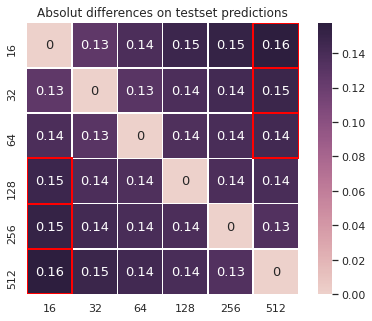

In [417]:
# Plotting the differences as heatmap
import operator

#mask = np.zeros_like(differences)
#mask[np.tril_indices_from(mask)] = True

#mask[np.diag_indices_from(mask)] = False

df = pd.DataFrame(data=differences, index=[16,32,64,128,256,512], columns=[16,32,64,128,256,512] )

f, ax = plt.subplots(figsize=(7,5))
cmap = sns.cubehelix_palette(as_cmap=True)


#fig = sns.heatmap(df, mask=mask, annot=True, square=True, linewidths=0.5, cmap=cmap)
fig = sns.heatmap(df, annot=True, square=True, linewidths=0.5, cmap=cmap, annot_kws={"fontsize":13})

for i,row in enumerate(df.iterrows()):
    _, series = row
    row_values = series.array
    index, value = max(enumerate(row_values), key=operator.itemgetter(1))
    fig.add_patch(Rectangle((index,i), 1, 1, fill=False, edgecolor='red', lw=2))

plt.title("Absolut differences on testset predictions")

plt.savefig('temp_plots/lastfm-predictions-diff.pdf', bbox_inches = 'tight')

In [418]:
# Compute the contradicting set of reachable items across latent dimension

d_reachability = []
set_lengths = []
alist = pd.read_csv("lastfm-dataset-1K/artist_genres_stats.csv", usecols=["artist_id"])
alist["status"] = 0
n_ambiguity = []

for n in range(len(reachable_items[16])):
    contr_reachability = np.zeros((6,6))
    for ind_d, d in enumerate(reachable_items):
        set_lengths.append(len(reachable_items[d][n])) # This is for plotting the set size in the heatmaps later
        for ind_d2, d2 in enumerate(reachable_items):
            set_diff = []
            set_diff2 = []
            if reachable_items[d][n].size <= reachable_items[d2][n].size:
                set_a = reachable_items[d][n]
                set_b = reachable_items[d2][n]
            else:
                set_b = reachable_items[d][n]
                set_a = reachable_items[d2][n]
            set_diff = np.setdiff1d(set_a, set_b).tolist() # This only counts the set difference that is in the smaller latent space but not in the larger 
            diff_length = len(set_diff)
            contr_reachability[ind_d][ind_d2] = diff_length
            for artist_id in set_diff:
                alist["status"][artist_id] = alist["status"][artist_id] + 1 # Weirdly artist_id is an index not an actual id
    n_ambigue = alist.loc[alist["status"] > 0]
    n_ambigue["status"] = (n_ambigue["status"] / 2).astype(int) # since we evaluate symmetry
    n_ambiguity.append(n_ambigue)
    alist["status"] = 0
    d_reachability.append(contr_reachability)


/home/robin/environments/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


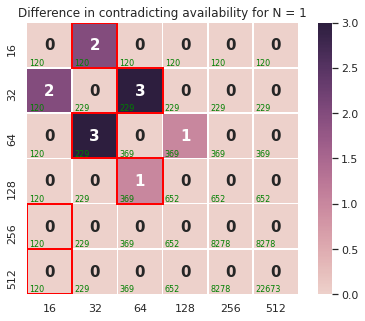

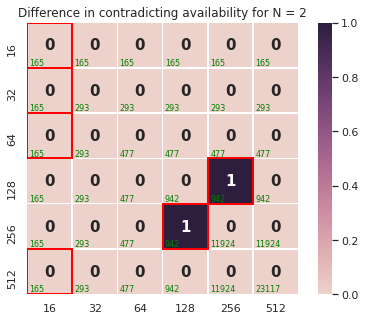

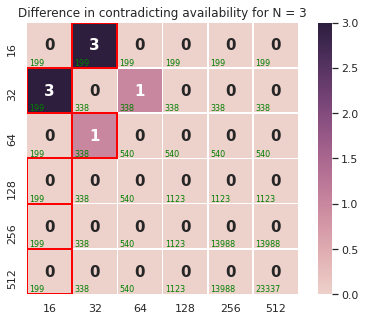

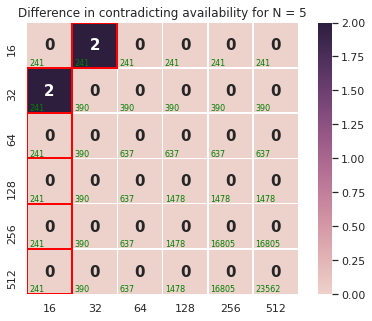

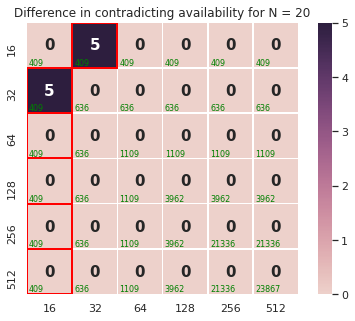

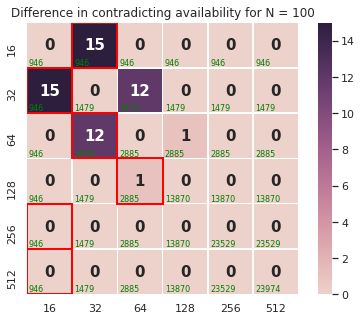

In [419]:
# Plot the contradicting set of reachable items across latent dimensions

for ind, n in enumerate(d_reachability):
    df = pd.DataFrame(data=n, index=[16,32,64,128,256,512], columns=[16,32,64,128,256,512] )

    f, ax = plt.subplots(figsize=(7,5))
    cmap = sns.cubehelix_palette(as_cmap=True)
    sns.heatmap(df, annot=True, square=True, linewidths=0.5, cmap=cmap, annot_kws={"fontsize":15, "fontweight": "bold"})
    
    for i,row in enumerate(df.iterrows()):
        _, series = row
        row_values = series.array
        index, value = max(enumerate(row_values), key=operator.itemgetter(1))
        ax.add_patch(Rectangle((index,i), 1, 1, fill=False, edgecolor='red', lw=2))
    
    
    
    set_sizes = set_lengths[(6*ind):(6*ind+6)]
    x = list(range(6))
    y = list(range(6))
    locations = [(i,j) for i in x for j in y]
    for loc in locations:
        x,y = loc
        size_ind = min(x,y)
        plt.text(x+0.05,y+0.79, set_sizes[size_ind], ha='left', va='top', color='green', fontsize=8)
    
    plt.title("Difference in contradicting availability for N = " + str(Ns[ind]))

    plt.savefig('temp_plots/lastfm-availability-diff-N=' + str(Ns[ind]) + '.pdf', bbox_inches = 'tight')

In [9]:
# # Compute the contradicting set of available items with different d and N

# d_reachability = np.zeros((36,36))
# d_reachability_percentage = np.zeros((36,36))
# set_lengths = []

# for n in range(len(reachable_items[16])):
#     for n2 in range(len(reachable_items[16])):
#         for ind_d, d in enumerate(reachable_items):
#             for ind_d2, d2 in enumerate(reachable_items):
#                 set_diff = []
#                 set_diff2 = []
#                 if reachable_items[d][n].size <= reachable_items[d2][n2].size :
#                     set_a = reachable_items[d][n]
#                     set_b = reachable_items[d2][n2]
#                     smaller_length = set_a.size
#                 else:
#                     set_b = reachable_items[d][n]
#                     set_a = reachable_items[d2][n2]
#                     smaller_length = set_b.size

#                 set_diff = np.setdiff1d(set_a, set_b).tolist() # This only counts the set difference that is in the smaller latent space but not in the larger 
#                 diff_length = len(set_diff)
#                 diff_length_percentage = (diff_length / smaller_length) * 100
#                 put_x = 6*n2 + ind_d2
#                 put_y = 6*n + ind_d
#                 #print("Iteration with N1 = " + str(n) + " N2 = " + str(n2) + " D1 = " + str(d) + " D2 = " + str(d2) + " SET DIFF: " + str(diff_length) + " at position " + "(" + str(put_x)+","+str(put_y)+")" )
#                 d_reachability[put_x][put_y] = diff_length
#                 d_reachability_percentage[put_x][put_y] = diff_length_percentage

In [420]:
# Compute the contradicting set of available items with different d and N

d_reachability = np.zeros((36,36))
d_reachability_percentage = np.zeros((36,36))
d_set_size = np.zeros((36, 36))
d_set_size_percentage = np.zeros((36, 36))
set_lengths = []

for n in range(len(reachable_items[16])):
    for n2 in range(len(reachable_items[16])):
        for ind_d, d in enumerate(reachable_items):
            for ind_d2, d2 in enumerate(reachable_items):
                set_diff = []
                set_diff2 = []
                if reachable_items[d][n].size <= reachable_items[d2][n2].size :
                    set_a = reachable_items[d][n]
                    set_b = reachable_items[d2][n2]
                    smaller_length = reachable_items[d][n].size
                else:
                    set_b = reachable_items[d][n]
                    set_a = reachable_items[d2][n2]
                    smaller_length = reachable_items[d2][n2].size
                set_diff = np.setdiff1d(set_a, set_b).tolist() # This only counts the set difference that is in the smaller latent space but not in the larger 
                diff_length = len(set_diff)
                diff_length_percentage = (diff_length / smaller_length)* 100
                put_x = 6*n2 + ind_d2
                put_y = 6*n + ind_d
                #print("Iteration with N1 = " + str(n) + " N2 = " + str(n2) + " D1 = " + str(d) + " D2 = " + str(d2) + " SET DIFF: " + str(diff_length) + " at position " + "(" + str(put_x)+","+str(put_y)+")" )
                d_reachability[put_x][put_y] = diff_length
                d_reachability_percentage[put_x][put_y] = diff_length_percentage
                size_difference = set_b.size - set_a.size
                d_set_size[put_x][put_y] = size_difference
                d_set_size_percentage[put_x][put_y] = (size_difference / set_b.size) *100

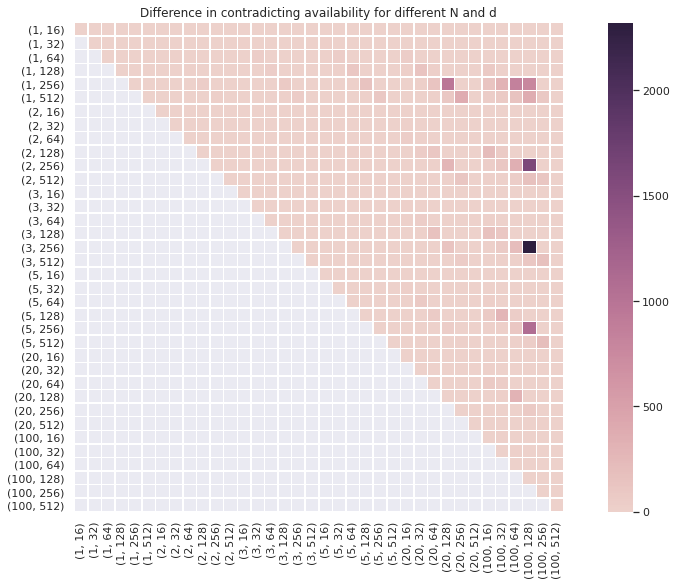

In [421]:
# Plotting the big boi matrix

tuples = []
for n in Ns:
    for d in ds:
        pos = (n,d)
        tuples.append(pos)
df = pd.DataFrame(data=d_reachability, index=tuples, columns=tuples)


mask = np.zeros_like(d_reachability)
mask[np.tril_indices_from(mask)] = True
mask[np.diag_indices_from(mask)] = False

f, ax = plt.subplots(figsize=(16,9))
cmap = sns.cubehelix_palette(as_cmap=True)

sns.heatmap(df, square=True, linewidths=0.5, cmap=cmap, mask=mask)

plt.title("Difference in contradicting availability for different N and d")

plt.savefig('temp_plots/lastfm-big-comp.pdf', bbox_inches = 'tight')

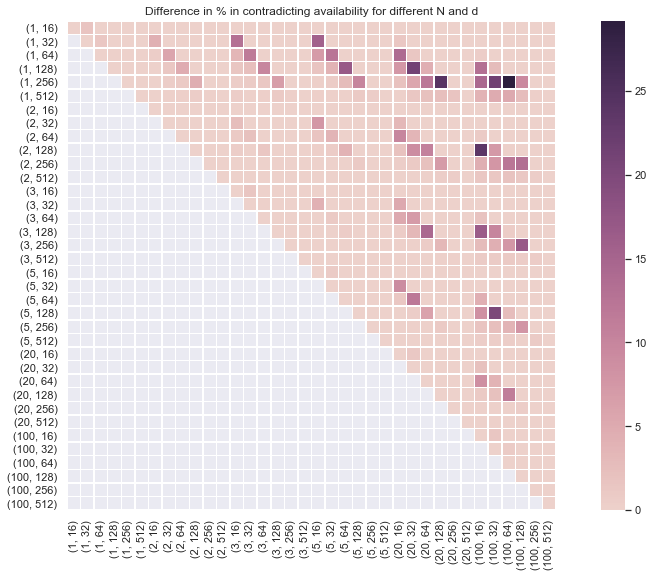

In [12]:
# Plotting the big boi matrix with percentages

tuples = []
for n in Ns:
    for d in ds:
        pos = (n,d)
        tuples.append(pos)
df = pd.DataFrame(data=d_reachability_percentage, index=tuples, columns=tuples)

f, ax = plt.subplots(figsize=(16,9))
cmap = sns.cubehelix_palette(as_cmap=True)

mask = np.zeros_like(d_reachability)
mask[np.tril_indices_from(mask)] = True
mask[np.diag_indices_from(mask)] = False

sns.heatmap(df, square=True, linewidths=0.5, cmap=cmap, mask=mask)

plt.title("Difference in % in contradicting availability for different N and d")

plt.savefig('temp_plots/lastfm-big-comp-percentage.pdf', bbox_inches = 'tight')

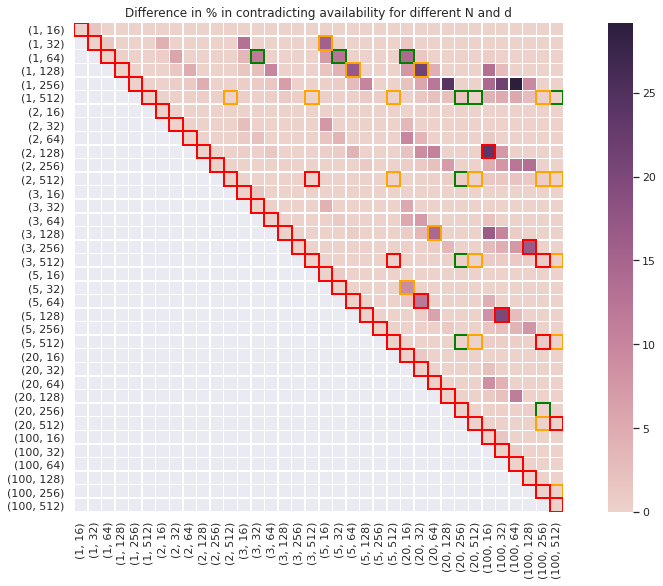

In [407]:
# Plotting the big boi matrix with percentages and marks similar size sets

tuples = []
for n in Ns:
    for d in ds:
        pos = (n,d)
        tuples.append(pos)
df = pd.DataFrame(data=d_reachability_percentage, index=tuples, columns=tuples)

f, ax = plt.subplots(figsize=(16,9))
cmap = sns.cubehelix_palette(as_cmap=True)

mask = np.zeros_like(d_reachability)
mask[np.tril_indices_from(mask)] = True
mask[np.diag_indices_from(mask)] = False

sns.heatmap(df, square=True, linewidths=0.5, cmap=cmap, mask=mask)

# Marks Cells with a set size difference of less than 10/5/1 percent in green/orange/red

for i in range(36):
    for j in range(0, i+1):
        if d_set_size_percentage[i][j] < 10:
            ax.add_patch(Rectangle((i,j), 1, 1, fill=False, edgecolor='green', lw=2))

for i in range(36):
    for j in range(0, i+1):
        if d_set_size_percentage[i][j] < 5:
            ax.add_patch(Rectangle((i,j), 1, 1, fill=False, edgecolor='orange', lw=2))

for i in range(36):
    for j in range(0, i+1):
        if d_set_size_percentage[i][j] < 1:
            ax.add_patch(Rectangle((i,j), 1, 1, fill=False, edgecolor='red', lw=2))
                        
            
plt.title("Difference in % in contradicting availability for different N and d")

plt.savefig('temp_plots/lastfm-big-comp-percentage.pdf', bbox_inches = 'tight')

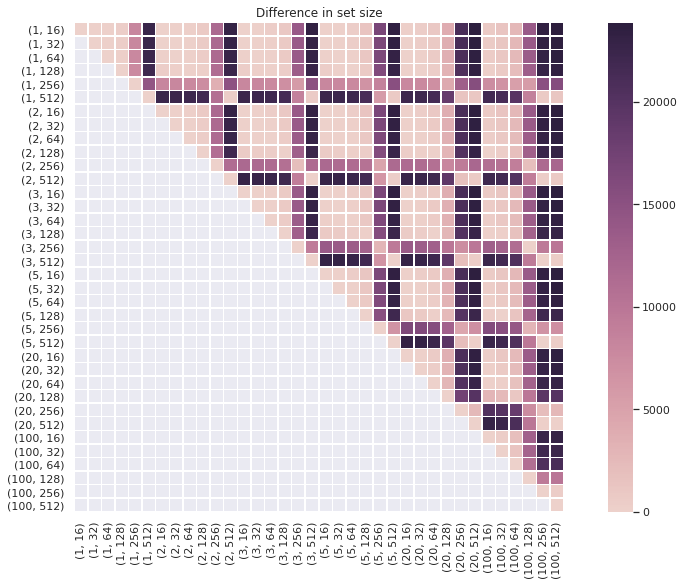

In [408]:
# Plotting the big boi matrix with difference in set size

tuples = []
for n in Ns:
    for d in ds:
        pos = (n,d)
        tuples.append(pos)
df = pd.DataFrame(data=d_set_size, index=tuples, columns=tuples)

f, ax = plt.subplots(figsize=(16,9))
cmap = sns.cubehelix_palette(as_cmap=True)

mask = np.zeros_like(d_reachability)
mask[np.tril_indices_from(mask)] = True
mask[np.diag_indices_from(mask)] = False

sns.heatmap(df, square=True, linewidths=0.5, cmap=cmap, mask=mask)

plt.title("Difference in set size")

plt.savefig('temp_plots/lastfm-big-comp-set-size.pdf', bbox_inches = 'tight')

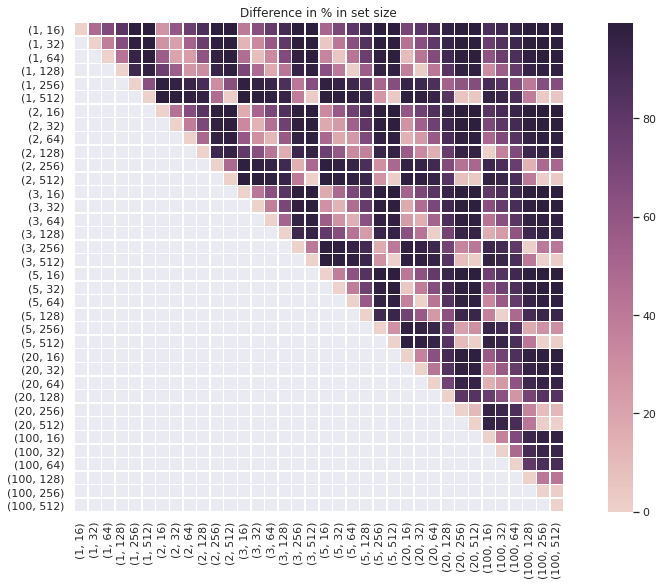

In [409]:
# Plotting the big boi matrix with difference in set size percentage

tuples = []
for n in Ns:
    for d in ds:
        pos = (n,d)
        tuples.append(pos)
df = pd.DataFrame(data=d_set_size_percentage, index=tuples, columns=tuples)

f, ax = plt.subplots(figsize=(16,9))
cmap = sns.cubehelix_palette(as_cmap=True)

mask = np.zeros_like(d_reachability)
mask[np.tril_indices_from(mask)] = True
mask[np.diag_indices_from(mask)] = False

sns.heatmap(df, square=True, linewidths=0.5, cmap=cmap, mask=mask)
       
plt.title("Difference in % in set size")

plt.savefig('temp_plots/lastfm-big-comp-set-size-percentage.pdf', bbox_inches = 'tight')

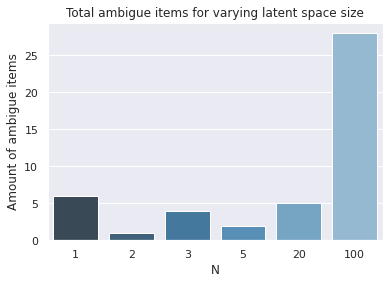

In [410]:
# Ambiguity Plotting
ambiguity = []
perc_ambiguity = []

for n_ambigue in n_ambiguity:
    ambiguity.append(n_ambigue["status"].size)
    
for size in ambiguity:
    perc_ambiguity.append(size/len(alist.index) * 100) 

    

d = {'N': Ns, 'ambiguity': ambiguity}
df = pd.DataFrame(d)
ax = sns.barplot(x='N', y = 'ambiguity', data=df, palette="Blues_d")
ax.set(ylabel='Amount of ambigue items', xlabel='N')
ax.set_title('Total ambigue items for varying latent space size')
plt.savefig('temp_plots/lastfm-ambiguity-varying-d.pdf', bbox_inches = 'tight')

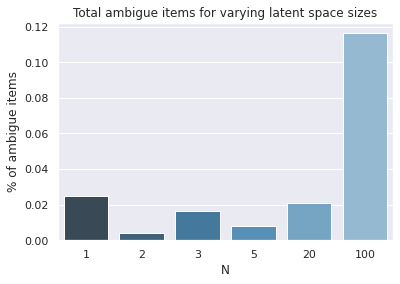

In [411]:
dp = {'N': Ns, 'ambiguity': perc_ambiguity}
dfp = pd.DataFrame(dp)
ax = sns.barplot(x='N', y = 'ambiguity', data=dfp, palette="Blues_d")
ax.set(ylabel='% of ambigue items', xlabel='N')
ax.set_title('Total ambigue items for varying latent space sizes')
plt.savefig('temp_plots/lastfm-ambiguity_perc-varying-d.pdf', bbox_inches = 'tight')

<h1>For MovieLens Dataset</h1>

In [18]:
# Load Models and Results

models = {}
results = {}

for d in ds:
    models[d] = np.load('ml-10M100K/ml_res_k='+str(d)+'.npz', allow_pickle=True)
    results[d] = np.load('ml-10M100K/results/ml_test_reachability_k='+str(d)+'.npz', allow_pickle=True)
    

In [19]:
# Storing Predictions, Reachable items

preds = {}
reachable_items = {}


for model_id in models:
    preds[model_id] = models[model_id]["preds"]
    
for results_id in results:
    reachable_items[results_id] = results[results_id]["reachable_items"]
    

In [20]:
# Calculate differences

differences = np.zeros((6,6))


for ind,i in enumerate(preds):
    for ind_2, j in enumerate(preds):
        diff = abs(preds[i] - preds[j])
        mean = np.mean(diff)
        differences[ind][ind_2] = mean

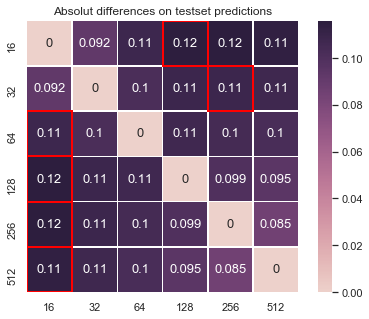

In [21]:
# Plotting the differences as heatmap
import operator


#mask = np.zeros_like(differences)
#mask[np.tril_indices_from(mask)] = True

#mask[np.diag_indices_from(mask)] = False

df = pd.DataFrame(data=differences, index=[16,32,64,128,256,512], columns=[16,32,64,128,256,512] )

f, ax = plt.subplots(figsize=(7,5))
cmap = sns.cubehelix_palette(as_cmap=True)


#fig = sns.heatmap(df, mask=mask, annot=True, square=True, linewidths=0.5, cmap=cmap)
fig = sns.heatmap(df, annot=True, square=True, linewidths=0.5, cmap=cmap, annot_kws={"fontsize":13})

for i,row in enumerate(df.iterrows()):
    _, series = row
    row_values = series.array
    index, value = max(enumerate(row_values), key=operator.itemgetter(1))
    fig.add_patch(Rectangle((index,i), 1, 1, fill=False, edgecolor='red', lw=2))

plt.title("Absolut differences on testset predictions")

plt.savefig('temp_plots/ml-predictions-diff.pdf', bbox_inches = 'tight')

In [22]:
# Compute the contradicting set of reachable items across latent dimension

d_reachability = []
set_lengths = []
mlist = pd.read_csv("ml-10M100K/movie_genres_stats.csv", usecols=["movie_id"])
mlist["status"] = 0
n_ambiguity = []



for n in range(len(reachable_items[16])):
    contr_reachability = np.zeros((6,6))
    for ind_d, d in enumerate(reachable_items):
        set_lengths.append(len(reachable_items[d][n])) # This is for plotting the set size in the heatmaps later
        for ind_d2, d2 in enumerate(reachable_items):
            set_diff = []
            set_diff2 = []
            if reachable_items[d][n].size <= reachable_items[d2][n].size:
                set_a = reachable_items[d][n]
                set_b = reachable_items[d2][n]
            else:
                set_b = reachable_items[d][n]
                set_a = reachable_items[d2][n]
            set_diff = np.setdiff1d(set_a, set_b).tolist() # This only counts the set difference that is in the smaller latent space but not in the larger 
            diff_length = len(set_diff)
            contr_reachability[ind_d][ind_d2] = diff_length
            for movie_id in set_diff:
                mlist["status"][movie_id] = mlist["status"][movie_id] + 1 # Weirdly movie_id is an index not an actual id
    n_ambigue = mlist.loc[mlist["status"] > 0]
    n_ambigue["status"] = (n_ambigue["status"] / 2).astype(int) # since we evaluate symmetry
    n_ambiguity.append(n_ambigue)
    mlist["status"] = 0
    d_reachability.append(contr_reachability)

/home/moritz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


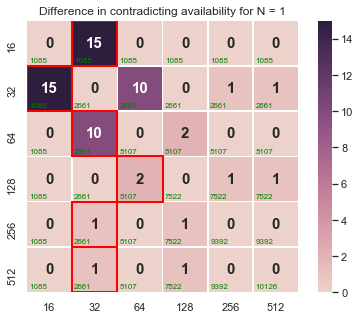

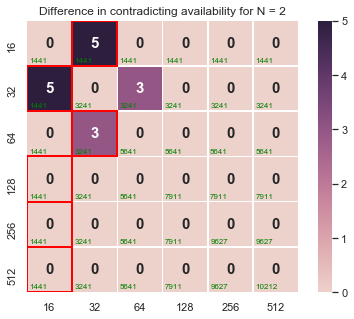

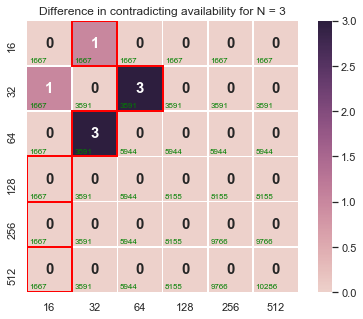

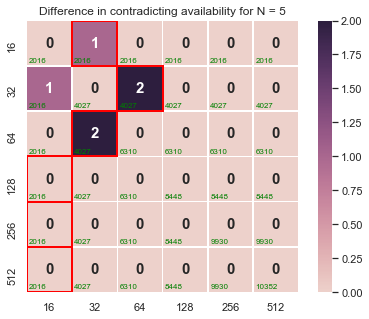

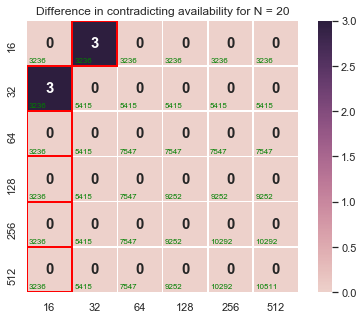

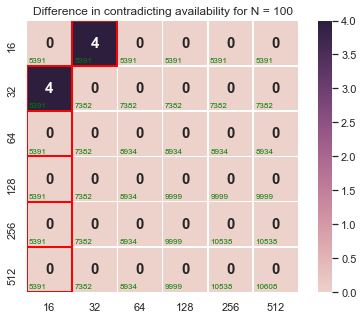

In [23]:
# Plot the contradicting set of reachable items across latent dimensions

for ind, n in enumerate(d_reachability):
    df = pd.DataFrame(data=n, index=[16,32,64,128,256,512], columns=[16,32,64,128,256,512] )

    f, ax = plt.subplots(figsize=(7,5))
    cmap = sns.cubehelix_palette(as_cmap=True)
    sns.heatmap(df, annot=True, square=True, linewidths=0.5, cmap=cmap, annot_kws={"fontsize":15, "fontweight": "bold"})
    
    for i,row in enumerate(df.iterrows()):
        _, series = row
        row_values = series.array
        index, value = max(enumerate(row_values), key=operator.itemgetter(1))
        ax.add_patch(Rectangle((index,i), 1, 1, fill=False, edgecolor='red', lw=2))
    
    
    
    set_sizes = set_lengths[(6*ind):(6*ind+6)]
    x = list(range(6))
    y = list(range(6))
    locations = [(i,j) for i in x for j in y]
    for loc in locations:
        x,y = loc
        size_ind = min(x,y)
        plt.text(x+0.05,y+0.81, set_sizes[size_ind], ha='left', va='top', color='green', fontsize=8)
    
    plt.title("Difference in contradicting availability for N = " + str(Ns[ind]))

    plt.savefig('temp_plots/ml-availability-diff-N=' + str(Ns[ind]) + '.pdf', bbox_inches = 'tight')

In [24]:
# Compute the contradicting set of available items with different d and N

d_reachability = np.zeros((36,36))
d_reachability_percentage = np.zeros((36,36))
d_set_size = np.zeros((36, 36))
d_set_size_percentage = np.zeros((36, 36))
set_lengths = []

for n in range(len(reachable_items[16])):
    for n2 in range(len(reachable_items[16])):
        for ind_d, d in enumerate(reachable_items):
            for ind_d2, d2 in enumerate(reachable_items):
                set_diff = []
                set_diff2 = []
                if reachable_items[d][n].size <= reachable_items[d2][n2].size :
                    set_a = reachable_items[d][n]
                    set_b = reachable_items[d2][n2]
                    smaller_length = reachable_items[d][n].size
                else:
                    set_b = reachable_items[d][n]
                    set_a = reachable_items[d2][n2]
                    smaller_length = reachable_items[d2][n2].size
                set_diff = np.setdiff1d(set_a, set_b).tolist() # This only counts the set difference that is in the smaller latent space but not in the larger 
                diff_length = len(set_diff)
                diff_length_percentage = (diff_length / smaller_length)* 100
                put_x = 6*n2 + ind_d2
                put_y = 6*n + ind_d
                #print("Iteration with N1 = " + str(n) + " N2 = " + str(n2) + " D1 = " + str(d) + " D2 = " + str(d2) + " SET DIFF: " + str(diff_length) + " at position " + "(" + str(put_x)+","+str(put_y)+")" )
                d_reachability[put_x][put_y] = diff_length
                d_reachability_percentage[put_x][put_y] = diff_length_percentage
                size_difference = set_b.size - set_a.size
                d_set_size[put_x][put_y] = size_difference
                d_set_size_percentage[put_x][put_y] = (size_difference / set_b.size) *100

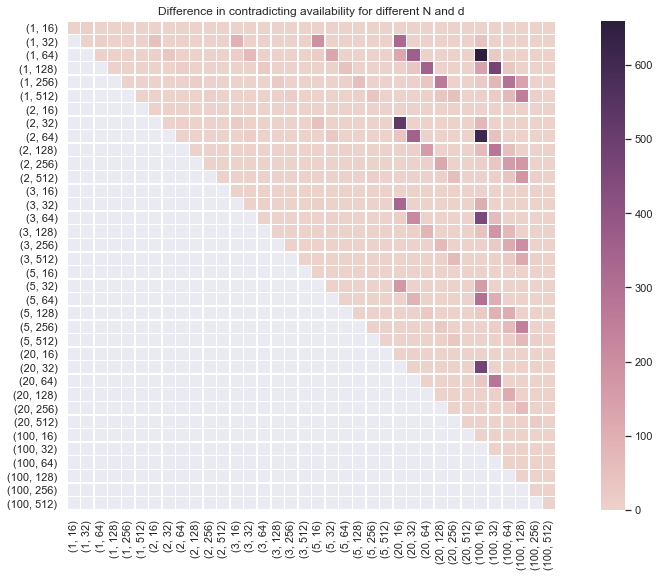

In [25]:
# Plotting the big boi matrix

tuples = []
for n in Ns:
    for d in ds:
        pos = (n,d)
        tuples.append(pos)
df = pd.DataFrame(data=d_reachability, index=tuples, columns=tuples)

f, ax = plt.subplots(figsize=(16,9))
cmap = sns.cubehelix_palette(as_cmap=True)

mask = np.zeros_like(d_reachability)
mask[np.tril_indices_from(mask)] = True
mask[np.diag_indices_from(mask)] = False

sns.heatmap(df, square=True, linewidths=0.5, cmap=cmap, mask=mask)

plt.title("Difference in contradicting availability for different N and d")

plt.savefig('temp_plots/ml-big-comp.pdf', bbox_inches = 'tight')

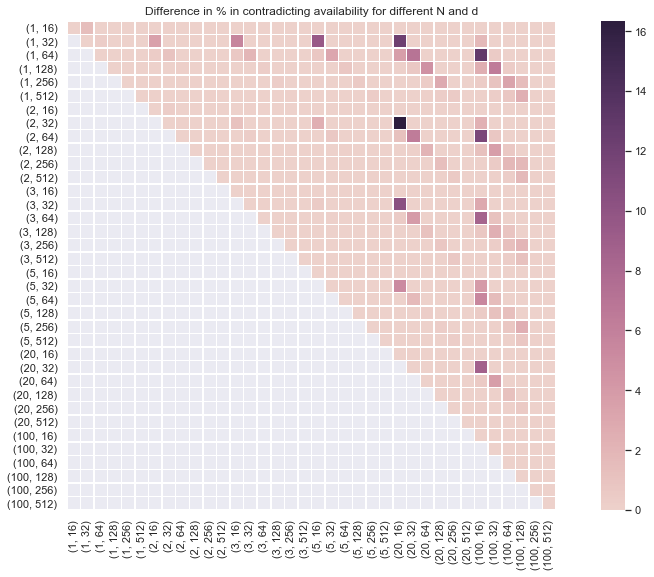

In [26]:
# Plotting the big boi matrix with percentages

tuples = []
for n in Ns:
    for d in ds:
        pos = (n,d)
        tuples.append(pos)
df = pd.DataFrame(data=d_reachability_percentage, index=tuples, columns=tuples)

f, ax = plt.subplots(figsize=(16,9))
cmap = sns.cubehelix_palette(as_cmap=True)

mask = np.zeros_like(d_reachability)
mask[np.tril_indices_from(mask)] = True
mask[np.diag_indices_from(mask)] = False

sns.heatmap(df, square=True, linewidths=0.5, cmap=cmap, mask=mask)       
            
plt.title("Difference in % in contradicting availability for different N and d")

plt.savefig('temp_plots/ml-big-comp-percentage.pdf', bbox_inches = 'tight')

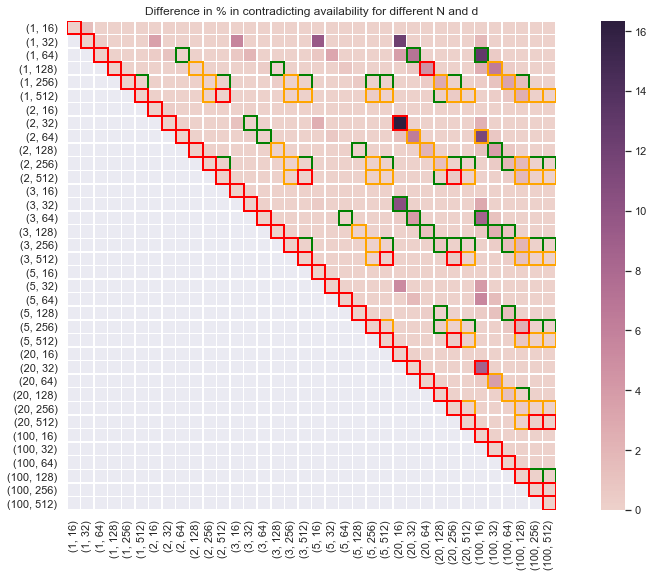

In [34]:
# Plotting the big boi matrix with percentages and marks similar size sets

tuples = []
for n in Ns:
    for d in ds:
        pos = (n,d)
        tuples.append(pos)
df = pd.DataFrame(data=d_reachability_percentage, index=tuples, columns=tuples)

f, ax = plt.subplots(figsize=(16,9))
cmap = sns.cubehelix_palette(as_cmap=True)

mask = np.zeros_like(d_reachability)
mask[np.tril_indices_from(mask)] = True
mask[np.diag_indices_from(mask)] = False

sns.heatmap(df, square=True, linewidths=0.5, cmap=cmap, mask=mask)

# Marks Cells with a set size difference of less than 10/5/1 percent in green/orange/red

for i in range(36):
    for j in range(0, i+1):
        if d_set_size_percentage[i][j] < 10:
            ax.add_patch(Rectangle((i,j), 1, 1, fill=False, edgecolor='green', lw=2))

for i in range(36):
    for j in range(0, i+1):
        if d_set_size_percentage[i][j] < 5:
            ax.add_patch(Rectangle((i,j), 1, 1, fill=False, edgecolor='orange', lw=2))

for i in range(36):
    for j in range(0, i+1):
        if d_set_size_percentage[i][j] < 1:
            ax.add_patch(Rectangle((i,j), 1, 1, fill=False, edgecolor='red', lw=2))
                        
            
plt.title("Difference in % in contradicting availability for different N and d")

plt.savefig('temp_plots/ml-big-comp-percentage.pdf', bbox_inches = 'tight')

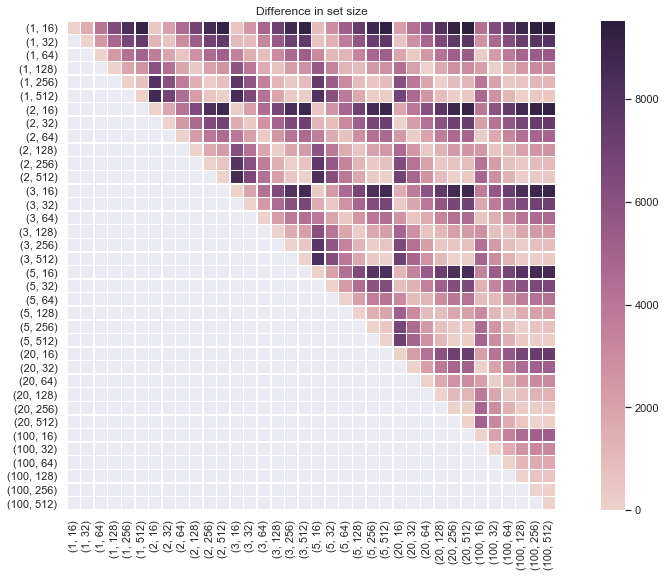

In [28]:
# Plotting the big boi matrix with difference in set size

tuples = []
for n in Ns:
    for d in ds:
        pos = (n,d)
        tuples.append(pos)
df = pd.DataFrame(data=d_set_size, index=tuples, columns=tuples)

f, ax = plt.subplots(figsize=(16,9))
cmap = sns.cubehelix_palette(as_cmap=True)

mask = np.zeros_like(d_reachability)
mask[np.tril_indices_from(mask)] = True
mask[np.diag_indices_from(mask)] = False

sns.heatmap(df, square=True, linewidths=0.5, cmap=cmap, mask=mask)

plt.title("Difference in set size")

plt.savefig('temp_plots/ml-big-comp-set-size.pdf', bbox_inches = 'tight')

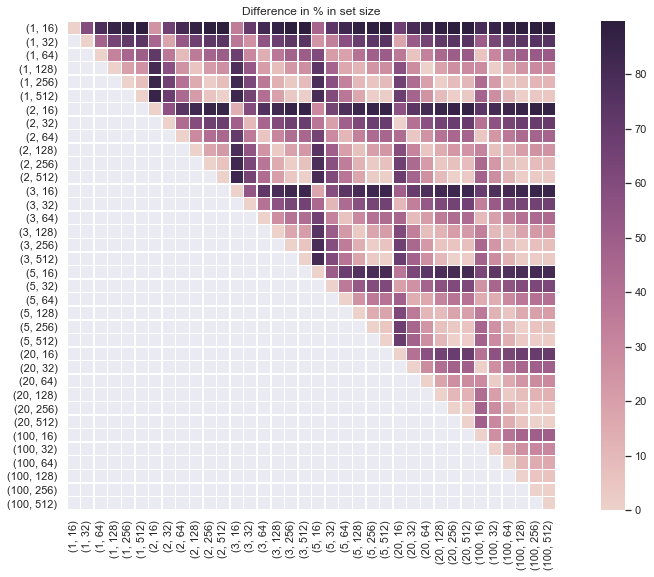

In [29]:
# Plotting the big boi matrix with difference in set size percentage

tuples = []
for n in Ns:
    for d in ds:
        pos = (n,d)
        tuples.append(pos)
df = pd.DataFrame(data=d_set_size_percentage, index=tuples, columns=tuples)

f, ax = plt.subplots(figsize=(16,9))
cmap = sns.cubehelix_palette(as_cmap=True)

mask = np.zeros_like(d_reachability)
mask[np.tril_indices_from(mask)] = True
mask[np.diag_indices_from(mask)] = False

sns.heatmap(df, square=True, linewidths=0.5, cmap=cmap, mask=mask)
       
plt.title("Difference in % in set size")

plt.savefig('temp_plots/ml-big-comp-set-size-percentage.pdf', bbox_inches = 'tight')

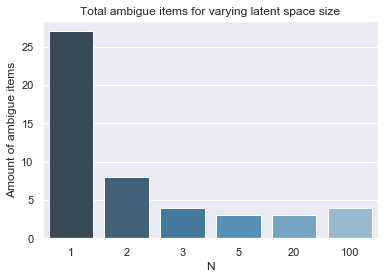

In [30]:
# Ambiguity Plotting
ambiguity = []
perc_ambiguity = []

for n_ambigue in n_ambiguity:
    ambiguity.append(n_ambigue["status"].size)
    
for size in ambiguity:
    perc_ambiguity.append(size/len(mlist.index) * 100) 

    

d = {'N': Ns, 'ambiguity': ambiguity}
df = pd.DataFrame(d)
ax = sns.barplot(x='N', y = 'ambiguity', data=df, palette="Blues_d")
ax.set(ylabel='Amount of ambigue items', xlabel='N')
ax.set_title('Total ambigue items for varying latent space size')
plt.savefig('temp_plots/ml-ambiguity-varying-d.pdf', bbox_inches = 'tight')

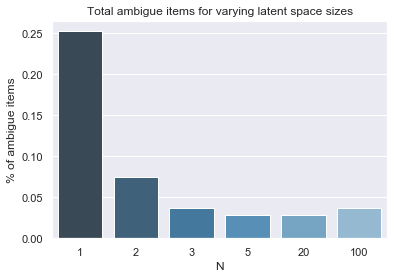

In [31]:
dp = {'N': Ns, 'ambiguity': perc_ambiguity}
dfp = pd.DataFrame(dp)
ax = sns.barplot(x='N', y = 'ambiguity', data=dfp, palette="Blues_d")
ax.set(ylabel='% of ambigue items', xlabel='N')
ax.set_title('Total ambigue items for varying latent space sizes')
plt.savefig('temp_plots/ml-ambiguity_perc-varying-d.pdf', bbox_inches = 'tight')